###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, G.F. Forsyth, C. Cooper. Based on [CFDPython](https://github.com/barbagroup/CFDPython), (c)2013 L.A. Barba, also under CC-BY license.

# Space & Time

## 1-D Diffusion

Welcome back! This is the third IPython Notebook of the series *Space and Time — Introduction of Finite-difference solutions of PDEs*, the second module of ["Practical Numerical Methods with Python"](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about). 

In the previous IPython notebooks of this series, we studied the numerical solution of the linear and non-linear convection equations using the finite-difference method, and learned about the CFL condition. Now, we will look at the one-dimensional diffusion equation:

\begin{equation}\frac{\partial u}{\partial t}= \nu \frac{\partial^2 u}{\partial x^2}\end{equation}

where $\nu$ is a constant known as the *diffusion coefficient*.

The first thing you should notice is that this equation has a second-order derivative. We first need to learn what to do with it!

### Discretizing 2nd-order derivatives

The second-order derivative can be represented geometrically as the line tangent to the curve given by the first derivative.  We will discretize the second-order derivative with a Central Difference scheme: a combination of forward difference and backward difference of the first derivative.  Consider the Taylor expansion of $u_{i+1}$ and $u_{i-1}$ around $u_i$:

$u_{i+1} = u_i + \Delta x \frac{\partial u}{\partial x}\big|_i + \frac{\Delta x^2}{2!} \frac{\partial ^2 u}{\partial x^2}\big|_i + \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\big|_i + {\mathcal O}(\Delta x^4)$

$u_{i-1} = u_i - \Delta x \frac{\partial u}{\partial x}\big|_i + \frac{\Delta x^2}{2!} \frac{\partial ^2 u}{\partial x^2}\big|_i - \frac{\Delta x^3}{3!} \frac{\partial ^3 u}{\partial x^3}\big|_i + {\mathcal O}(\Delta x^4)$

If we add these two expansions, the odd-numbered derivatives will cancel out.  Neglecting any terms of ${\mathcal O}(\Delta x^4)$ or higher (and really, those are very small), we can rearrange the sum of these two expansions to solve for the second-derivative.  

$u_{i+1} + u_{i-1} = 2u_i+\Delta x^2 \frac{\partial ^2 u}{\partial x^2}\big|_i + {\mathcal O}(\Delta x^4)$

And finally:

\begin{equation}\frac{\partial ^2 u}{\partial x^2}=\frac{u_{i+1}-2u_{i}+u_{i-1}}{\Delta x^2} + {\mathcal O}(\Delta x^2)\end{equation}

The central difference approximation of the 2nd-order derivative is 2nd-order accurate.


### Back to diffusion

We can now write the discretized version of the diffusion equation in 1D:

\begin{equation}\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\nu\frac{u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n}}{\Delta x^2}\end{equation}

As before, we notice that once we have an initial condition, the only unknown is $u_{i}^{n+1}$, so we re-arrange the equation to isolate this term:

\begin{equation}u_{i}^{n+1}=u_{i}^{n}+\frac{\nu\Delta t}{\Delta x^2}(u_{i+1}^{n}-2u_{i}^{n}+u_{i-1}^{n})\end{equation}

This discrete equation allows us to write a program that advances a solution in time—but we need an initial condition. Let's continue using our favorite: the hat function. So, at $t=0$, $u=2$ in the interval $0.5\le x\le 1$ and $u=1$ everywhere else.

### Stability of the diffusion equation

The diffusion equation is not free of stability constraints. Just like the linear and non-linear convection equations, there are a set of discretization parameters $\Delta x$ and $\Delta t$ that will make the numerical solution blow up. For the diffusion equation and the discretization used here, the stability condition for diffusion is

$$
\begin{equation}
\nu \frac{\Delta t}{\Delta x^2} \leq \frac{1}{2}
\end{equation}
$$

### And solve!

 We are ready to number-crunch!

The next two code cells initialize the problem by loading the needed libraries, then defining the solution parameters and initial condition. This time, we don't let the user choose just *any* $\Delta t$, though; we have decided this is not safe: people just like to blow things up. Instead, the code calculates a value of $\Delta t$ that will be in the stable range, according to the spatial discretization chosen! You can now experiment with different solution parameters to see how the numerical solution changes, but it won't blow up.

In [22]:
import numpy                       
from matplotlib import pyplot    

%pylab inline
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

Populating the interactive namespace from numpy and matplotlib


In [25]:
nx = 41
dx = 2./(nx-1)
nt = 100   
nu = 0.3   #the value of viscosity
sigma = .2 
dt = sigma*dx**2/nu 

x = numpy.linspace(0,2,nx)
ubound = numpy.where(x >= 0.5)
lbound = numpy.where(x <= 1)

u = numpy.ones(nx)      
u[numpy.intersect1d(lbound, ubound)] = 2  

un = numpy.ones(nx) 

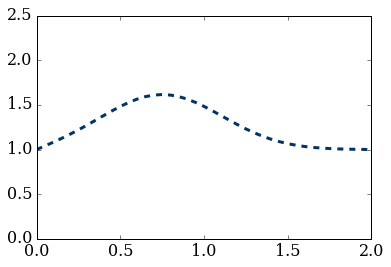

In [26]:
for n in range(nt):  
    un = u.copy() 
    u[1:-1] = un[1:-1] + nu*dt/dx**2*(un[2:] -2*un[1:-1] +un[0:-2]) 
        
pyplot.plot(x, u, color='#003366', ls='--', lw=3)
pyplot.ylim(0,2.5);

## Animations

Looking at before-and-after plots of the wave in motion is helpful, but it's even better if we can see it changing! For displaying animated results within the notebook, there is a handy library called JSAnimation. To install it, [follow these instructions](https://github.com/numerical-mooc/numerical-mooc/wiki/HOWTO:-Install-JSAnimation-for-IPython-Notebook).

First, let's import the animation libraries:

In [27]:
#from JSAnimation.IPython_display import display_animation
from JSAnimation import IPython_display
from matplotlib import animation

Now we need to reset our initial conditions!

In [28]:
nt = 50

u = numpy.ones(nx)      
u[numpy.intersect1d(lbound,ubound)] = 2  

un = numpy.ones(nx) 

Now we have to create an animation.  This takes a few steps, but it's actually not hard to do!  First, we need to create a `figure` and add `axes`.  The `figure` defines the plot we want to animate.  The `axes` lets us create elements of the plot that we can change interactively.  Then we create a "blank" line that we will update at each iteration. Like this: 

```Python
fig = pyplot.figure(figsize=(11,8))
ax = pyplot.axes(xlim=(0,2), ylim=(1,3))
line = ax.plot([], [], lw=2)[0]
```

**Note**: The `[0]` after the `ax.plot()` command is required, since `ax.plot` can (optionally) return several values.  Since we're only creating one line, we ask it for the "zeroth" (and only...) line.  

Now that our `figure` is set up, we can define a function to evolve our solution plot.  This will be exactly the same as the code for the numerical solution, except that we also want to "update" the data of the solution line at each iteration.  

```Python
def diffusion(i):
    line.set_data(x,u)
    
    un = u.copy() 
    u[1:-1] = un[1:-1] + nu*dt/dx**2*\
            (un[2:] - 2*un[1:-1] + un[0:-2]) 
```

Finally, we can initialize our animation using `animation.FuncAnimation()`.  We're going to pass the following arguments:

*  `fig`: the name of our figure
*  `diffusion`: the name of our solver function
*  `frames`: the number of frames to draw (which we set equal to `nt`)
*  `interval`: the number of milliseconds each frame appears for

Let's put it all together. It's time to animate!


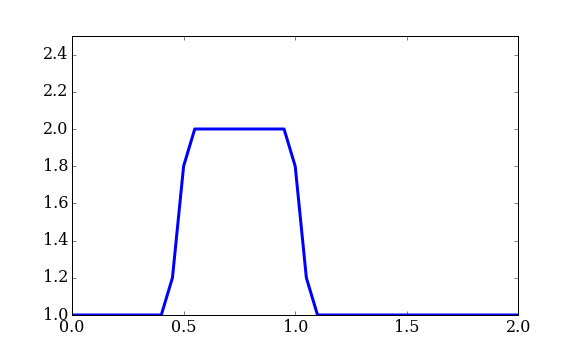
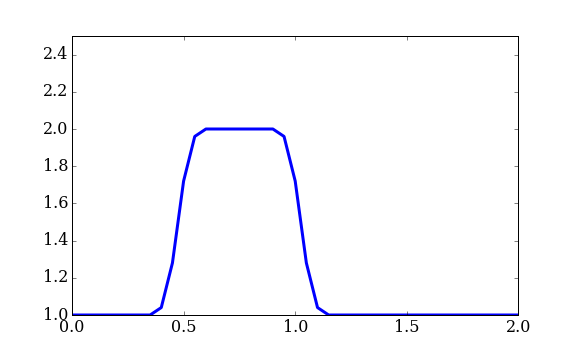
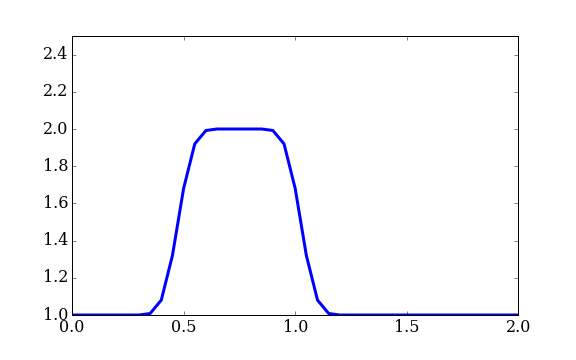
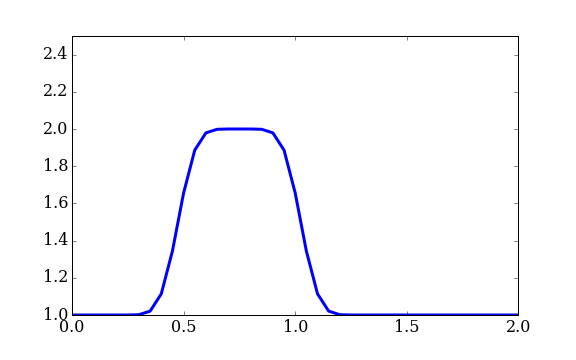
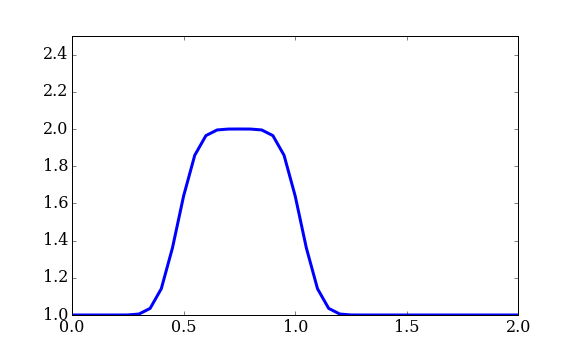
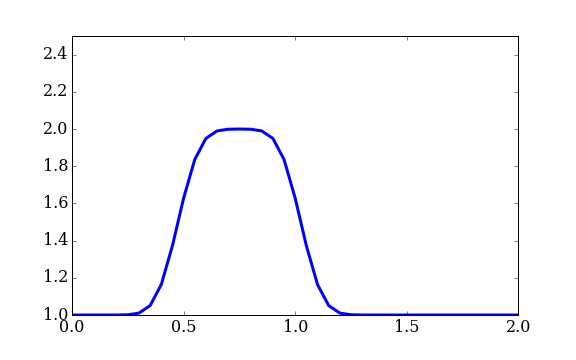
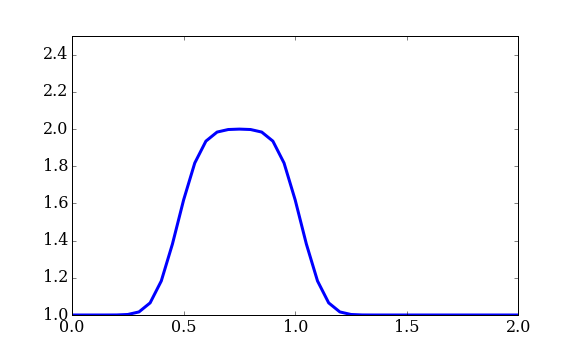
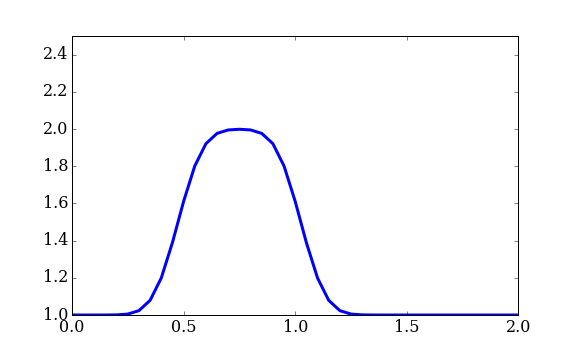
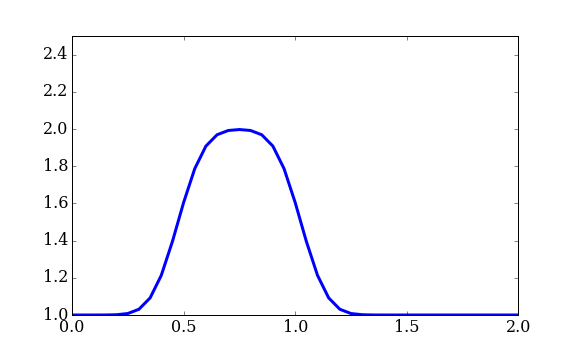
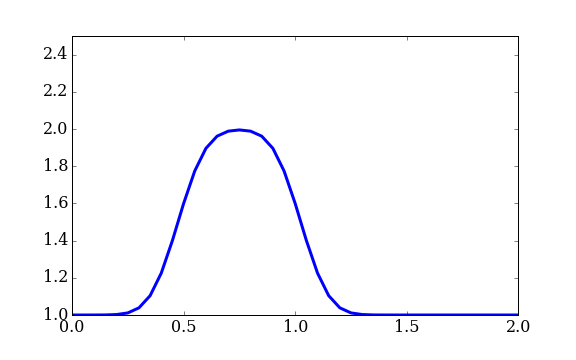
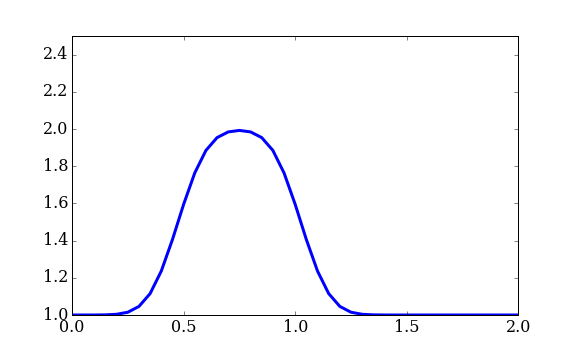
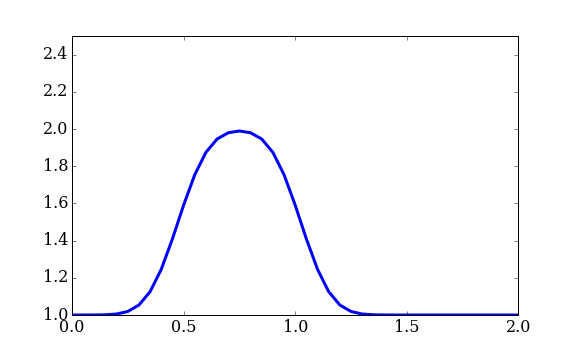
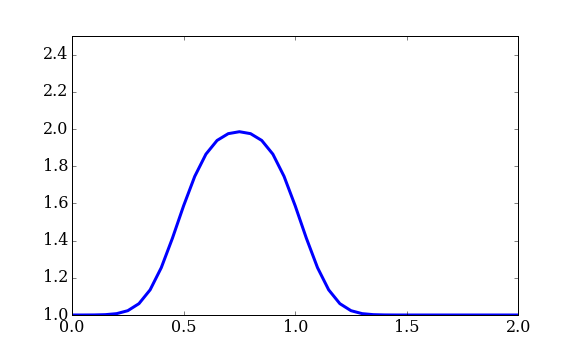
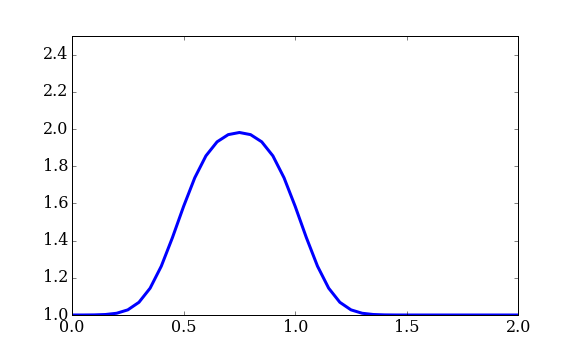
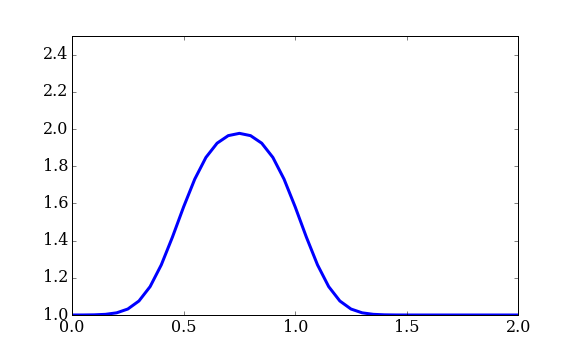
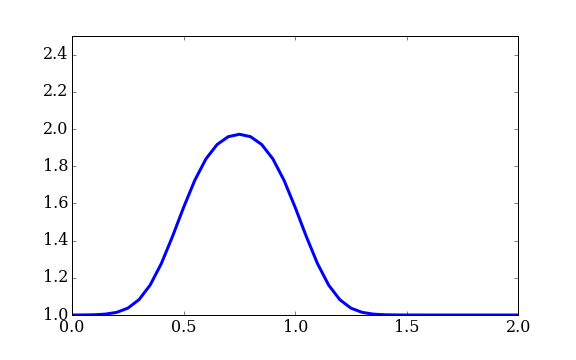
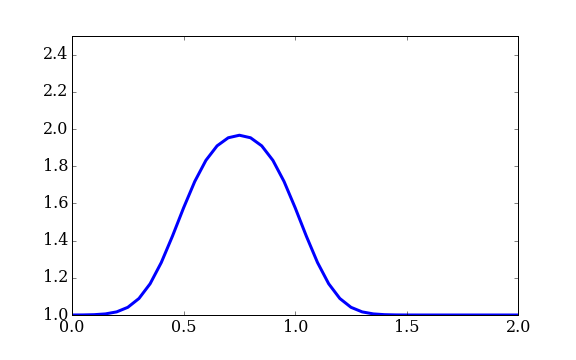
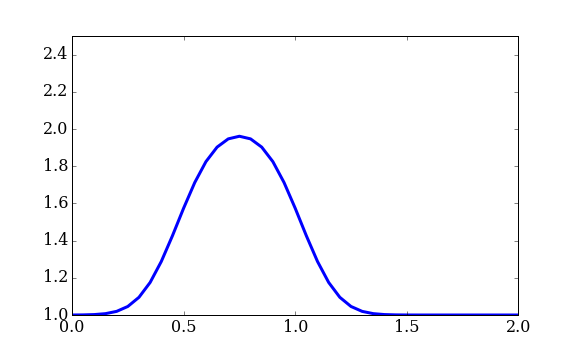
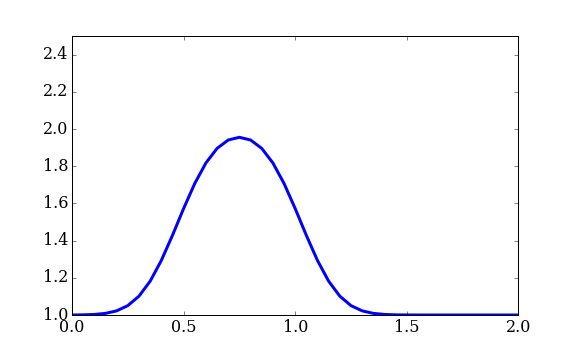
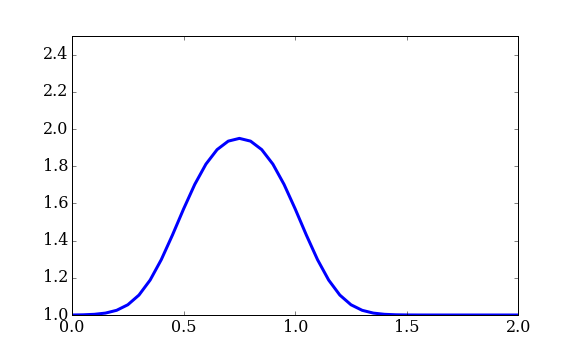
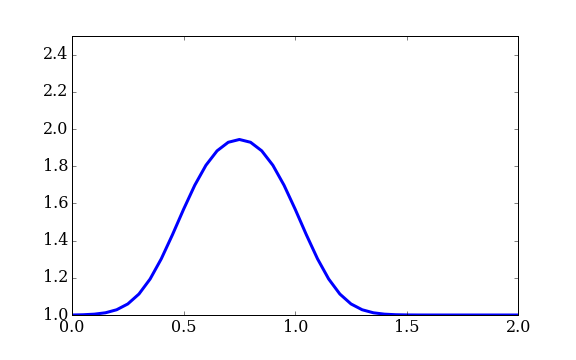
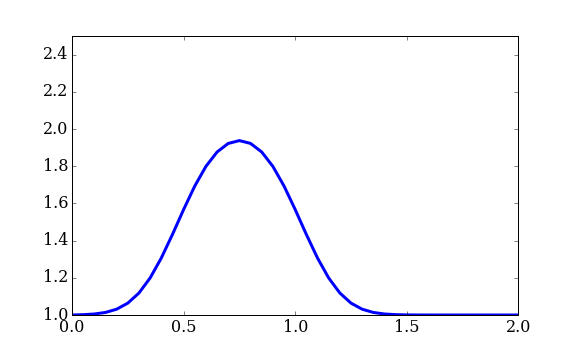
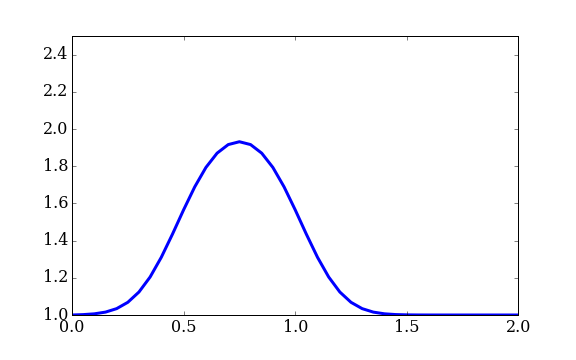
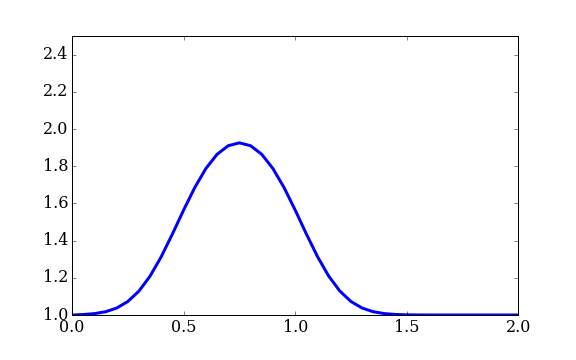
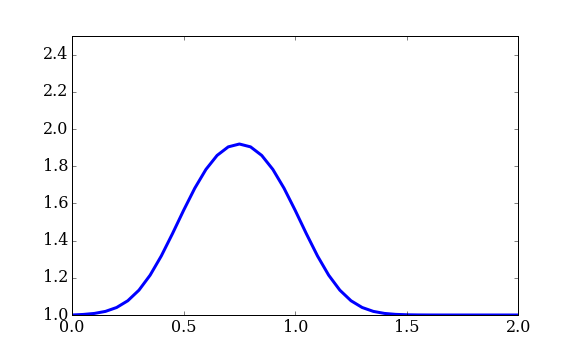
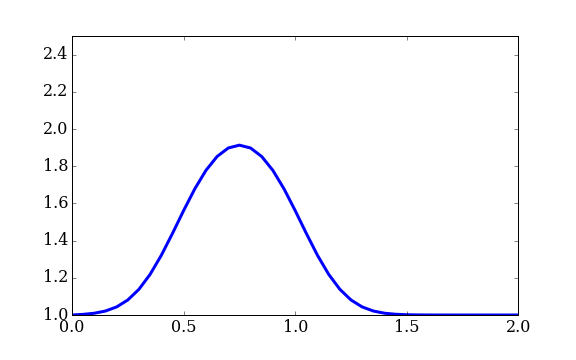
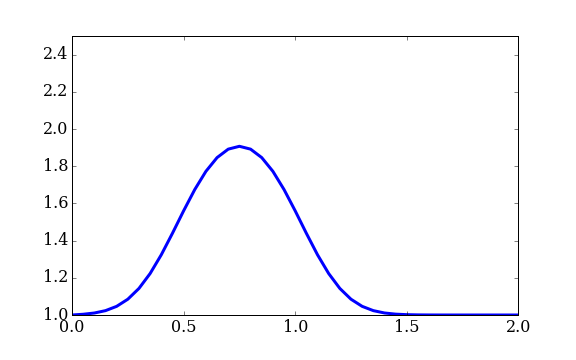
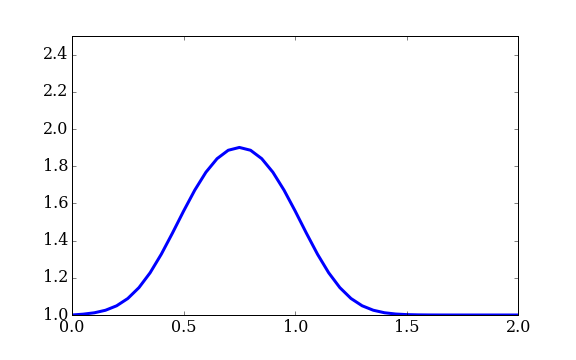
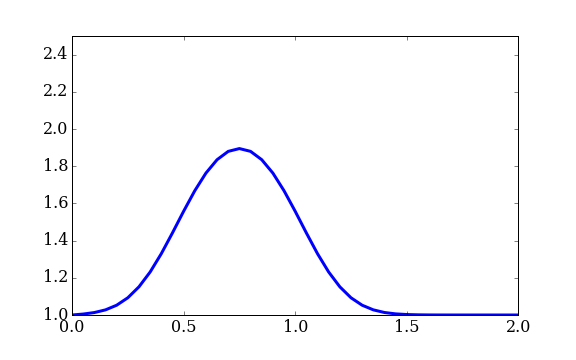
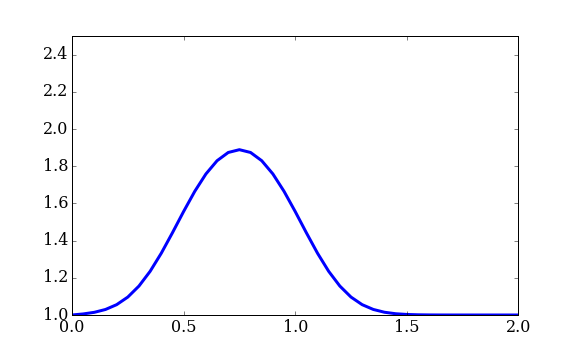
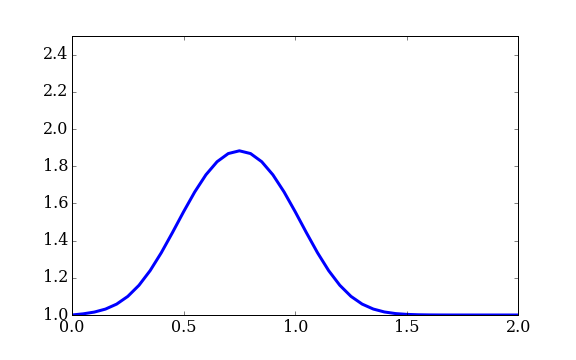
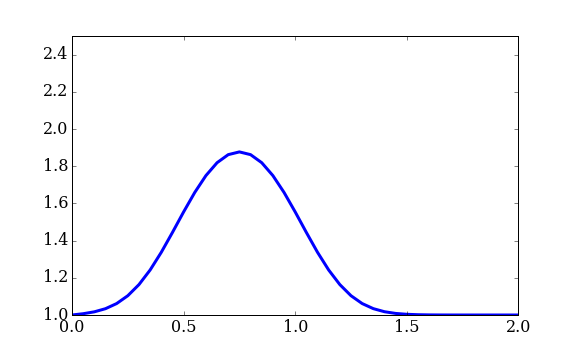
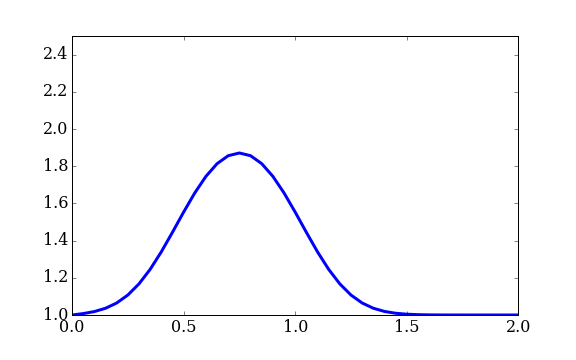
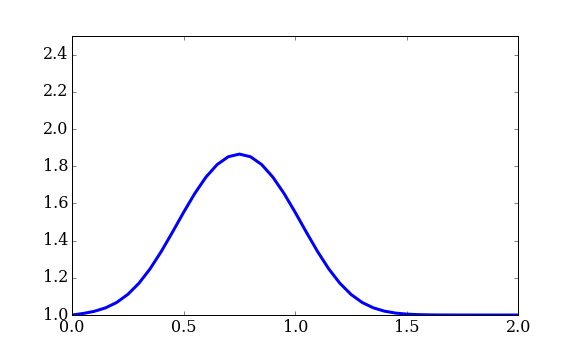
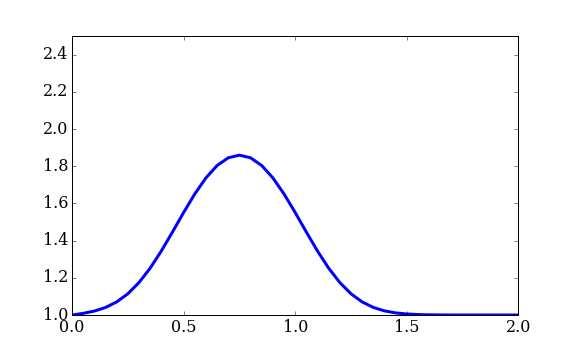
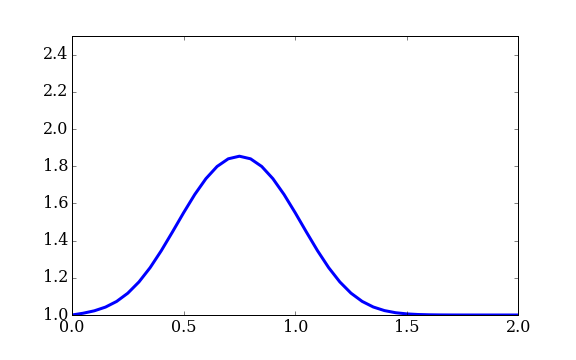
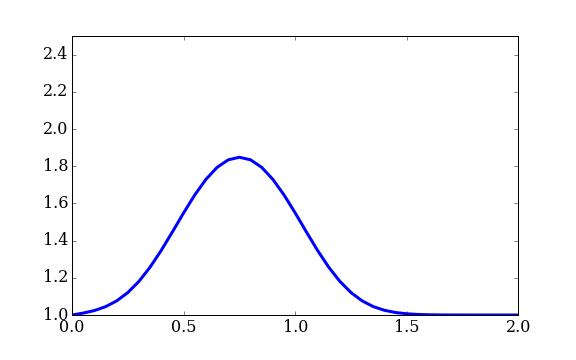
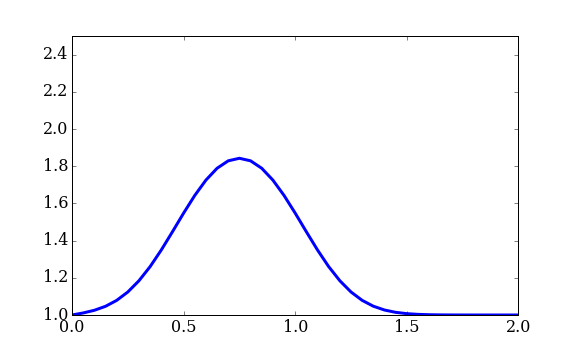
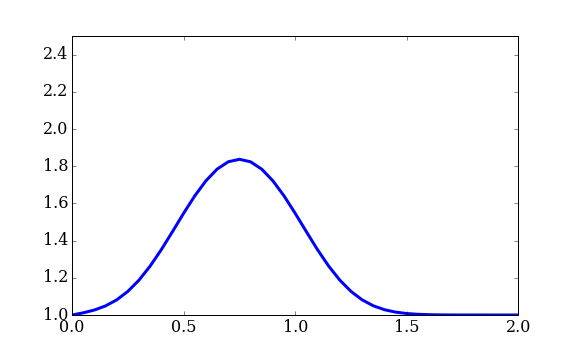
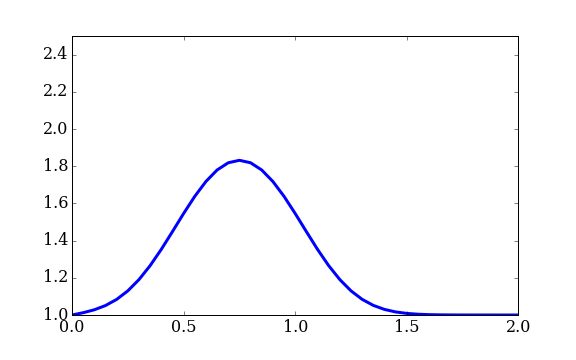
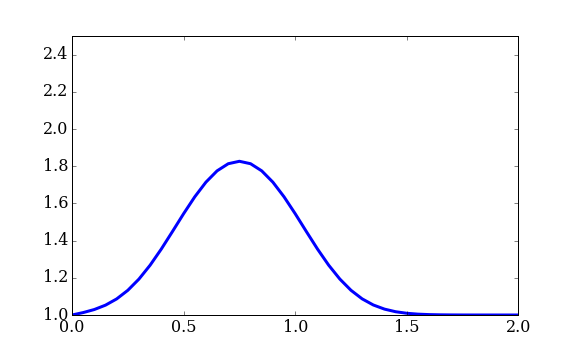
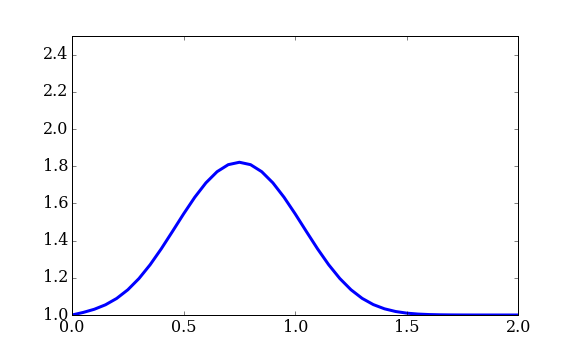
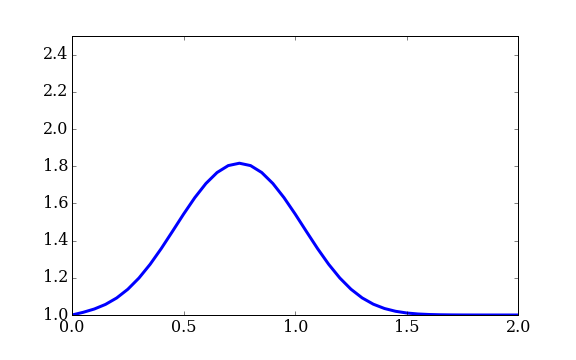
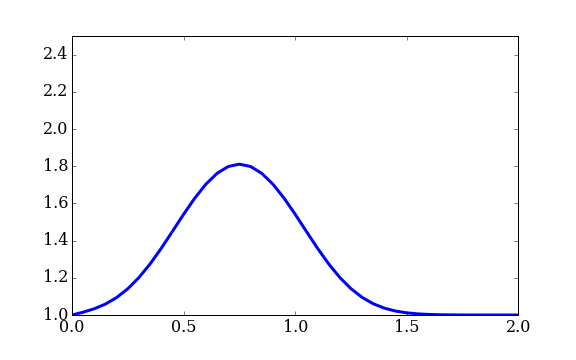
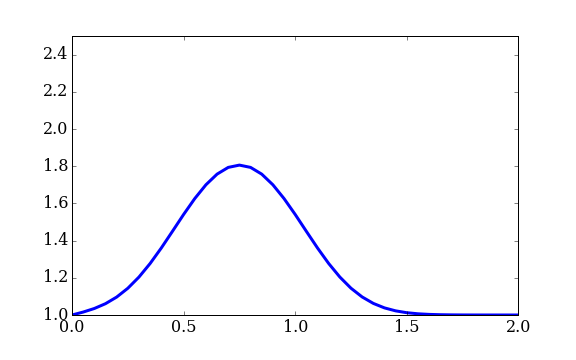
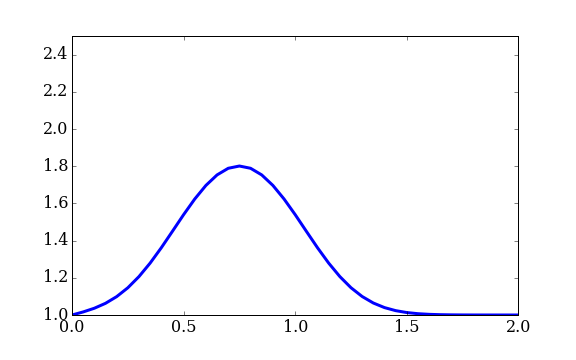
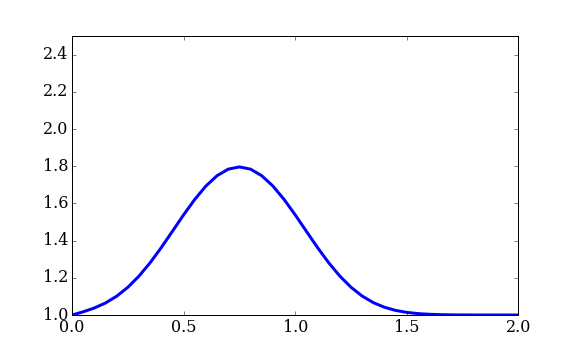
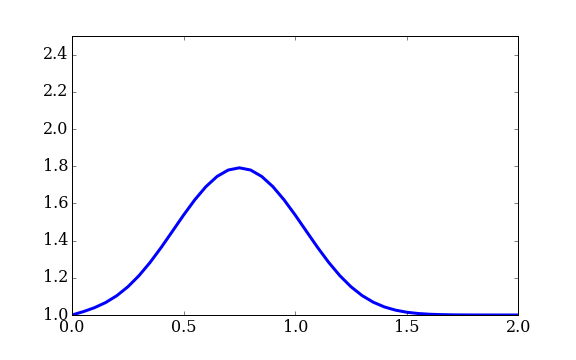
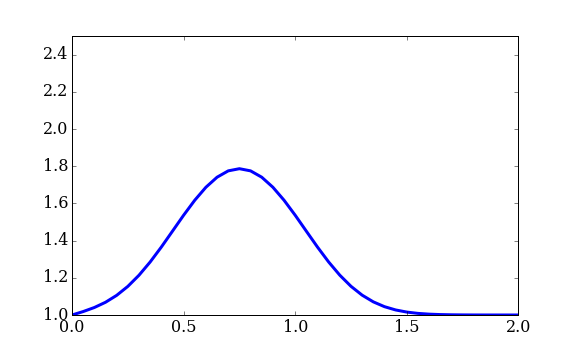
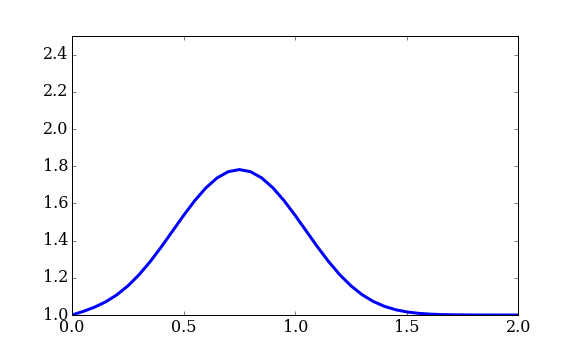

In [29]:
fig = pyplot.figure(figsize=(8,5))
ax = pyplot.axes(xlim=(0,2), ylim=(1,2.5))
line, = ax.plot([], [], lw=3)


def init():
    line.set_data([], [])
    return line,

def diffusion(i):
    line.set_data(x,u)
    un = u.copy() 
    u[1:-1] = un[1:-1] + nu*dt/dx**2*(un[2:] -2*un[1:-1] +un[0:-2])
   
    

animation.FuncAnimation(fig, diffusion, init_func=init, frames=nt, interval=100)

In [ ]:
print(u[1:-1])

---

###### The cell below loads the style of the notebook.

In [ ]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())